In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [3]:
def convertDate(d):
    date = datetime.datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
    return datetime.date(date.year, date.month, date.day)

In [4]:
complaints = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', converters={'Created Date': convertDate})

In [5]:
complaints.columns

Index([u'Unique Key', u'Created Date', u'Complaint Type', u'Descriptor'], dtype='object')

In [6]:
complaints.iloc[0]

Unique Key                  31901130
Created Date              2015-11-04
Complaint Type    Noise - Commercial
Descriptor          Loud Music/Party
Name: 0, dtype: object

In [7]:
groups = complaints.groupby('Created Date')

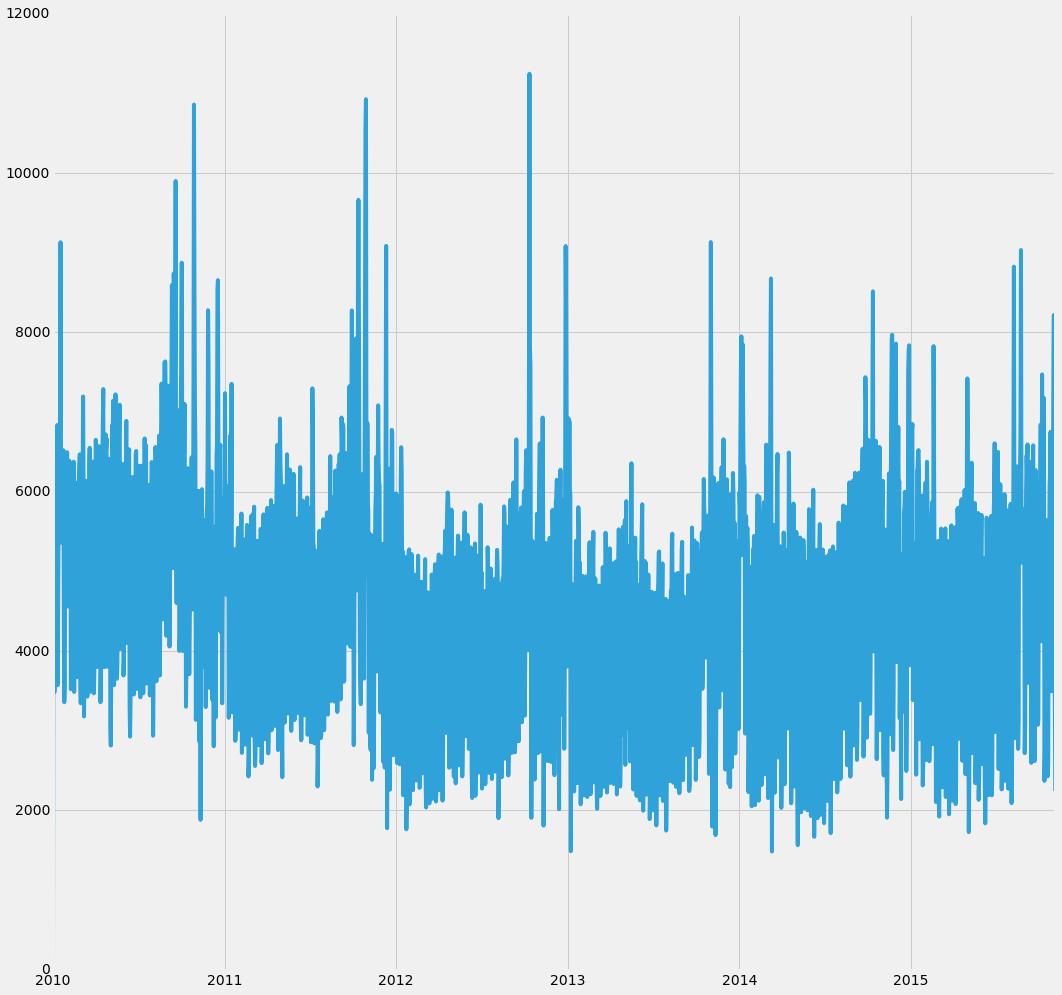

In [15]:
figure, ax = pl.subplots(figsize=(16,16))
ax.plot(complaints['Created Date'].unique(), groups.count()['Unique Key'])

In [36]:
cycle, trend = sma.tsa.filters.hpfilter(groups.count()['Unique Key'], lamb = 129600)

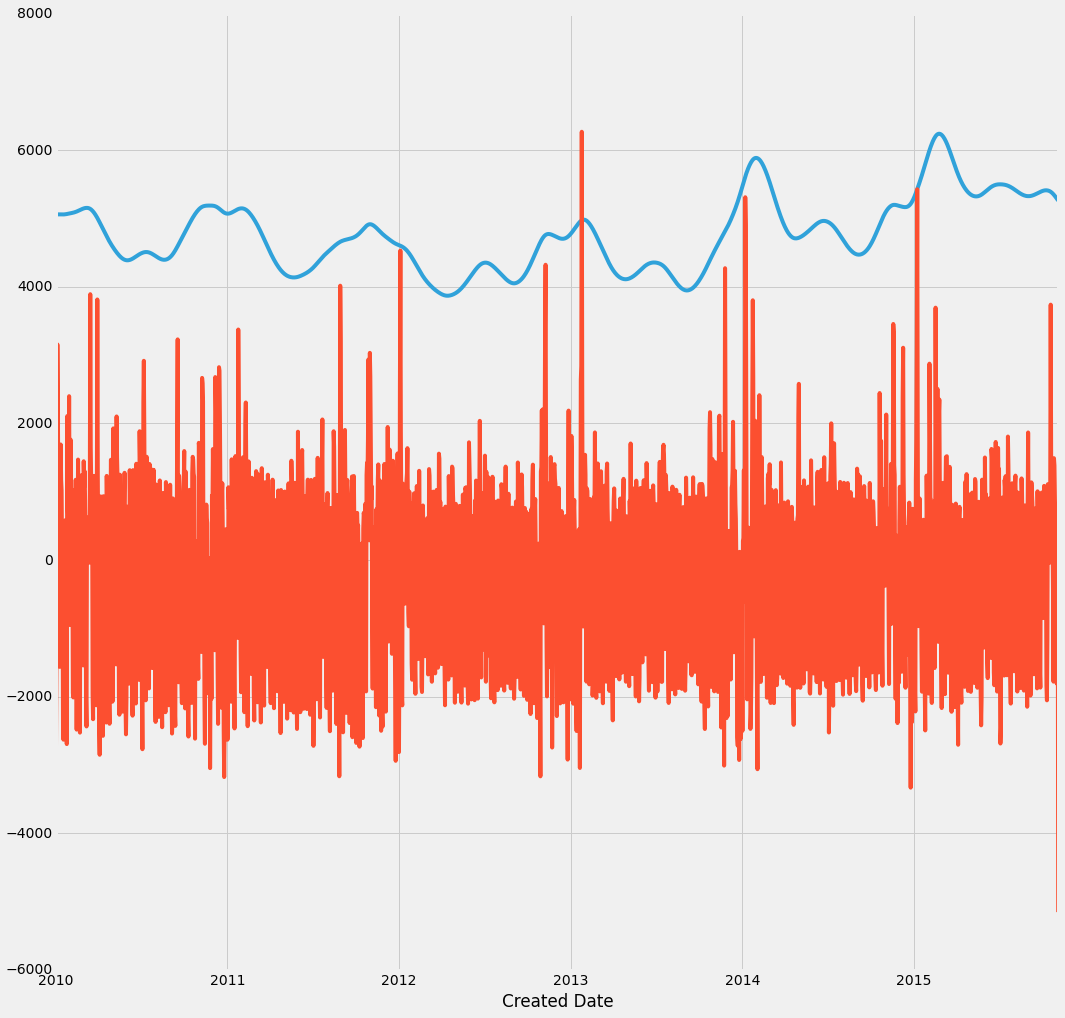

In [37]:
figure, ax = pl.subplots(figsize=(16,16))
trend.plot()
cycle.plot()

In [28]:
complaints = complaints.rename(columns = {'Created Date': 'Date'})
complaints['dow'] = complaints.apply(lambda x: x['Date'].weekday(), axis=1)

In [33]:
groups = complaints.groupby('Created Date')

In [37]:
d = {
    'dow': groups.mean()['dow'],
    'count': groups.count()['dow'],
    'date': complaints['Created Date'].unique()
}

mod = smf.ols(formula='count ~ C(dow)', data = d).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     472.8
Date:                Thu, 05 Nov 2015   Prob (F-statistic):               0.00
Time:                        16:15:16   Log-Likelihood:                -17665.
No. Observations:                2134   AIC:                         3.534e+04
Df Residuals:                    2127   BIC:                         3.538e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    5503.5902     54.613    100.774      

In [13]:
def convertStreak(streak):
    # N is post season?
    #if streak == "N":
    #    return float('Nan')
    if not streak:
        return float('Nan')
    sign = -1 if streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return datetime.date(d.year, d.month, d.day)
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") # Drop header rows
    ])
    
    #print [d.days for d in np.diff(df.Date)]
    
    # First game in double headers
    df = df.drop(df.index[(np.append([d.days for d in np.diff(df.Date)], [1]) == 0)])
    
    return df

In [14]:
dfs = []
years = range(2010,2016)
for year in years:
    dfs.append(readGameLog("teams_NYM_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    
baseball = pd.concat(dfs, ignore_index=True)

In [21]:
#Flag for postseason games
baseball['postseason'] = np.isnan(baseball.Rk.astype('float'))

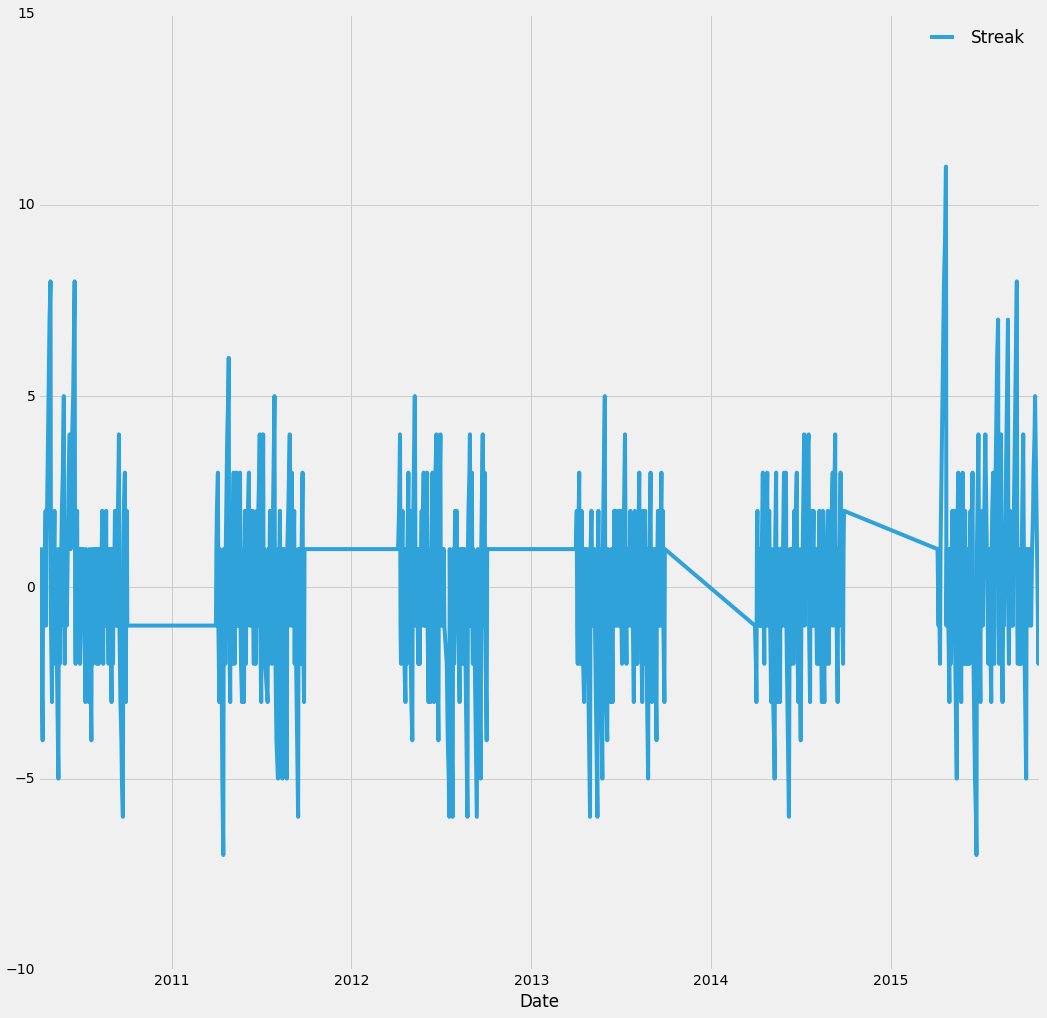

In [22]:
baseball.plot('Date', 'Streak', figsize=(16,16))

In [29]:
merged = pd.merge(baseball, complaints, on='Date')

In [30]:
grouped = merged.groupby('Date')

In [31]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.493
Date:                Sun, 08 Nov 2015   Prob (F-statistic):             0.0619
Time:                        13:23:04   Log-Likelihood:                -8367.0
No. Observations:                 970   AIC:                         1.674e+04
Df Residuals:                     968   BIC:                         1.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4449.9445     43.350    102.651      0.0

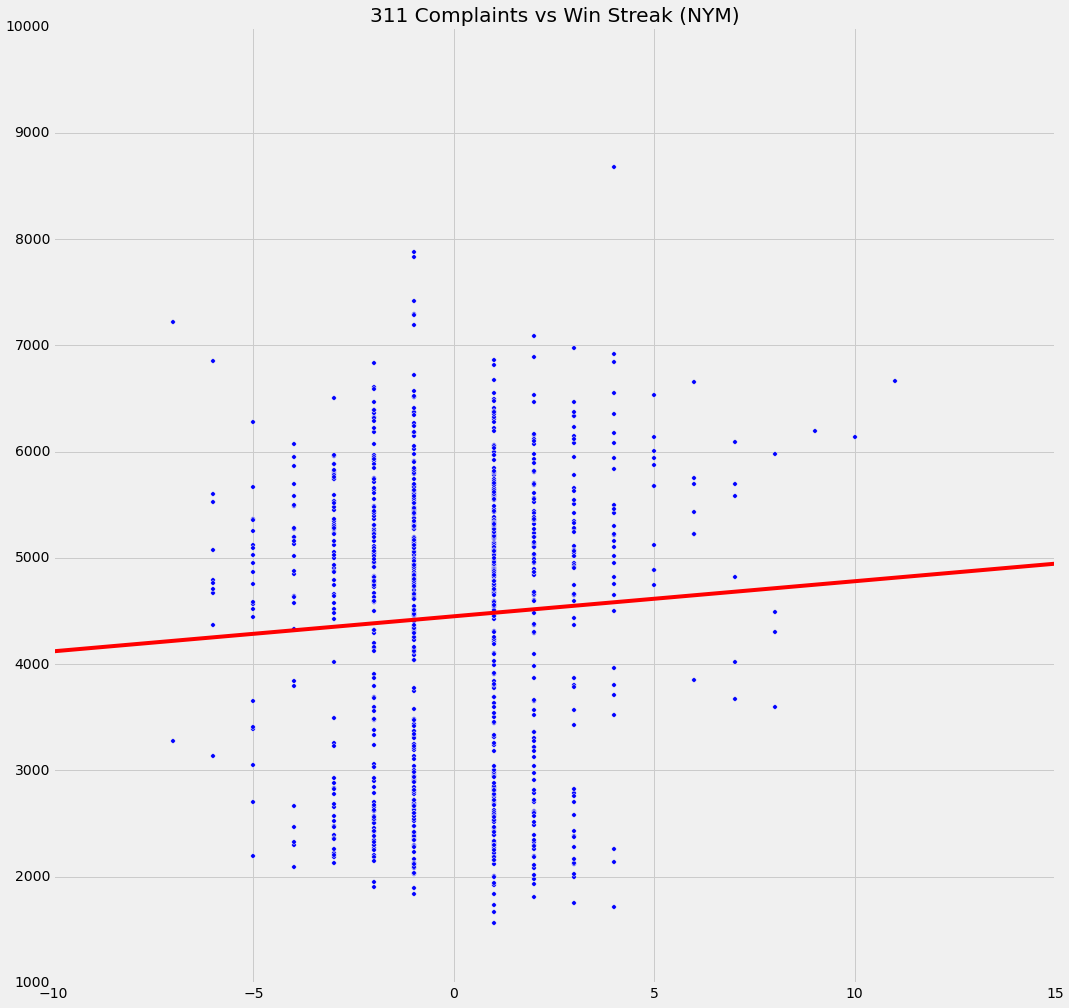

In [32]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('311 Complaints vs Win Streak (NYM)')

In [33]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     346.4
Date:                Sun, 08 Nov 2015   Prob (F-statistic):          8.12e-258
Time:                        13:23:13   Log-Likelihood:                -7758.4
No. Observations:                 970   AIC:                         1.553e+04
Df Residuals:                     962   BIC:                         1.557e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5118.6858     71.599     71.491      0.0

In [60]:
noise = merged[merged['Complaint Type'].str.contains('Noise')]

In [64]:
grouped = noise.groupby('Date')

In [34]:
streak = []
counts = []
dow = []
post = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    post.append(grouped.get_group(d).postseason.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.450
Date:                Thu, 05 Nov 2015   Prob (F-statistic):              0.229
Time:                        16:33:39   Log-Likelihood:                -6330.6
No. Observations:                 956   AIC:                         1.267e+04
Df Residuals:                     954   BIC:                         1.267e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    409.0964      5.887     69.491      0.0

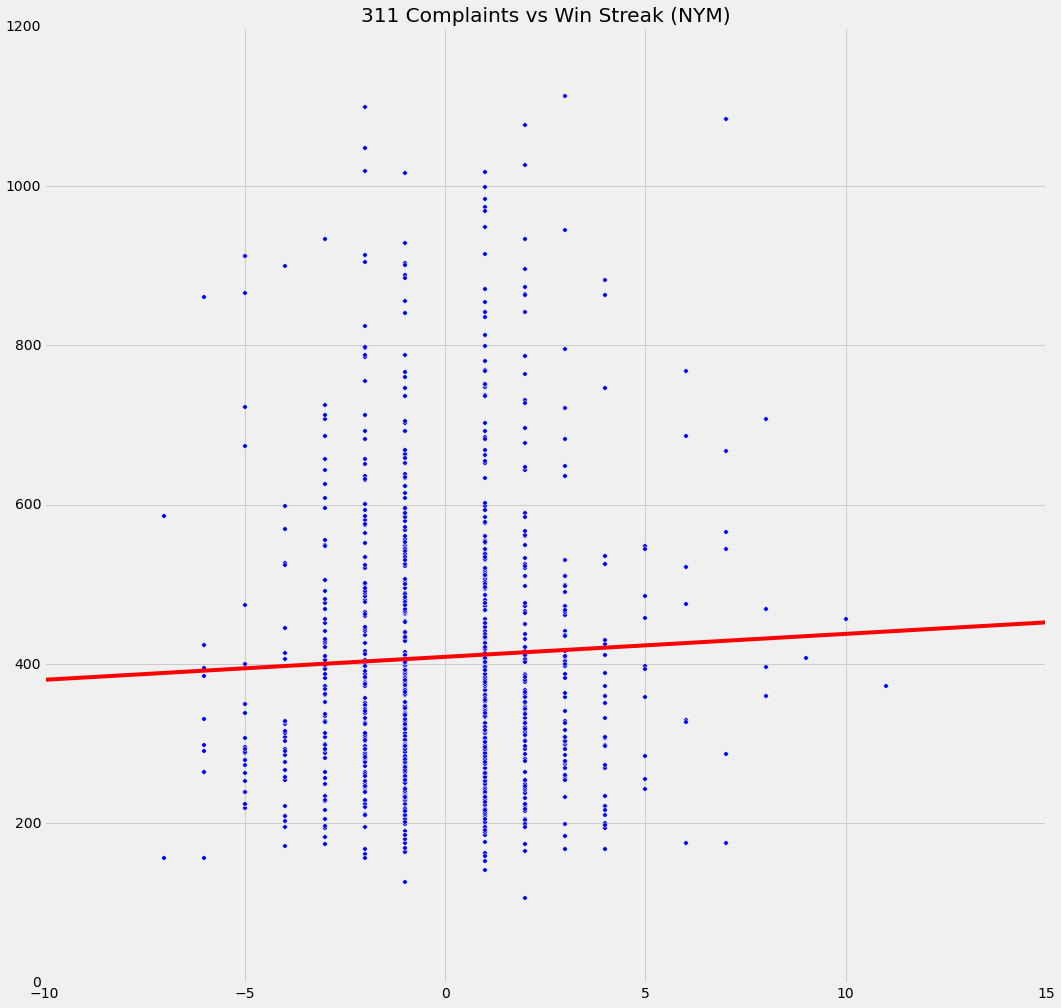

In [66]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('311 Complaints vs Win Streak (NYM)')

In [35]:
mod = smf.ols(formula='c ~ s + C(d) + p', data = {'c': counts, 's': streak, 'd': dow, 'p': post}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     316.5
Date:                Sun, 08 Nov 2015   Prob (F-statistic):          3.52e-263
Time:                        13:26:00   Log-Likelihood:                -7742.9
No. Observations:                 970   AIC:                         1.550e+04
Df Residuals:                     961   BIC:                         1.555e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5108.0449     70.527     72.427      0.0

In [68]:
wonoise = merged[~merged['Complaint Type'].str.contains('Noise')]

In [69]:
grouped = wonoise.groupby('Date')

In [70]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

In [71]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     458.0
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          5.69e-299
Time:                        16:37:59   Log-Likelihood:                -7579.9
No. Observations:                 956   AIC:                         1.518e+04
Df Residuals:                     948   BIC:                         1.521e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4780.0707     67.124     71.213      0.0

In [41]:
cycle, trend = sma.tsa.filters.hpfilter(counts, lamb = 129600)

In [47]:
mod = smf.ols(formula='c ~ s + C(d) + p', data = {'c': cycle, 's': streak, 'd': dow, 'p': post}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     515.2
Date:                Sun, 08 Nov 2015   Prob (F-statistic):               0.00
Time:                        13:32:33   Log-Likelihood:                -7501.5
No. Observations:                 970   AIC:                         1.502e+04
Df Residuals:                     961   BIC:                         1.506e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    672.1127     54.993     12.222      0.0